In [1]:
from __future__ import print_function
import morphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

/usr/local/anaconda/envs/morphs/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pair_df = morphs.load.pop_pair_df()
morphs.data.parse.morph_dim(pair_df)

In [3]:
from statsmodels.formula.api import ols

In [4]:
def categorical(group, spect_dist_control=False):
    sampled_points = group["lesser_morph_pos"].unique()
    boundaries = (
        sampled_points[:-1] + sampled_points[1:]
    ) / 2.0
    intercepts = np.zeros(boundaries.shape)
    cis = np.zeros([2, boundaries.shape[0]])
    for i, boundary in enumerate(boundaries):
        group["contains_midpoint"] = (
            group["greater_morph_pos"] > boundary
        ) & (boundary > group["lesser_morph_pos"])
        if spect_dist_control:
            formula = "red_neural_cosine_dist ~ spect_euclidean_dist + C(contains_midpoint)"
        else:
            formula = "red_neural_cosine_dist ~ C(contains_midpoint)"
        lm = ols(formula, data=group)
        fit = lm.fit()
        intercepts[i] = fit.params.loc[
            "C(contains_midpoint)[T.True]"
        ]
        cis[:, i] = (
            fit.conf_int()
            .loc["C(contains_midpoint)[T.True]"]
            .values
        )
    return sampled_points, intercepts, cis


In [5]:
cat_df = pair_df.groupby(["block_path", "morph_dim"]).apply(categorical)

In [6]:
cat_df = cat_df.to_frame().reset_index()
morphs.data.parse.morph_dim(cat_df)

In [7]:
cat_df["bird_id"] = cat_df["block_path"].map(morphs.data.parse.bird_id)

In [8]:
def cat_viz(
    cat_df, title="", row_order="abcdef", col_order="cdefgh"
):
    g = sns.FacetGrid(
        cat_df,
        col="greater_dim",
        row="lesser_dim",
        row_order=row_order,
        col_order=col_order,
    )

    all_birds = list(
        set(cat_df["bird_id"].unique())
        | set(morphs.subj.BEHAVE_SUBJS)
    )
    colors = sns.color_palette("husl", len(all_birds))
    color_dict = {
        subj: color
        for subj, color in zip(all_birds, colors)
    }
    psychometric_params = morphs.load.psychometric_params()

    g.map_dataframe(
        _cat_viz,
        psychometric_params=psychometric_params,
        color_dict=color_dict,
    )
    g.set_titles("{row_name}     to     {col_name}")
    g.set_axis_labels("Morph Position", "Categoricality")
    if title:
        plt.subplots_adjust(top=0.95)
        g.fig.suptitle(title)
    g.despine(top=True, right=True, left=True, bottom=True)
    g.set(xticks=[], yticks=[])


def _cat_viz(
    psychometric_params,
    color_dict,
    scale=True,
    softmax=True,
    **kwargs
):
    data = kwargs.pop("data")
    ax = plt.gca()
    morph_dim = data["morph_dim"].values[0]
    for index, row in data.iterrows():
        subj = row["bird_id"]
        sampled_points, intercepts, cis = row[0]
        x = sampled_points.repeat(2)[1:-1]
        y = intercepts.repeat(2)
        cis_y = cis.repeat(2, axis=1)
        if scale:
            scale_factor = np.max(np.abs(y))
            y /= scale_factor
            cis_y /= scale_factor
        if softmax:
            scale_factor = np.sum(np.exp(y))
            y = np.exp(y) / scale_factor
            cis_y = np.exp(cis_y) / scale_factor
        ax.plot(x, y, color=color_dict[subj], label=subj)
        ax.fill_between(
            x,
            cis_y[0, :],
            cis_y[1, :],
            color=color_dict[subj],
            alpha=0.25,
        )
    for bsubj in psychometric_params:
        if morph_dim in psychometric_params[bsubj]:
            ax.axvline(
                psychometric_params[bsubj][morph_dim][3],
                color=color_dict[bsubj],
                label=bsubj,
            )


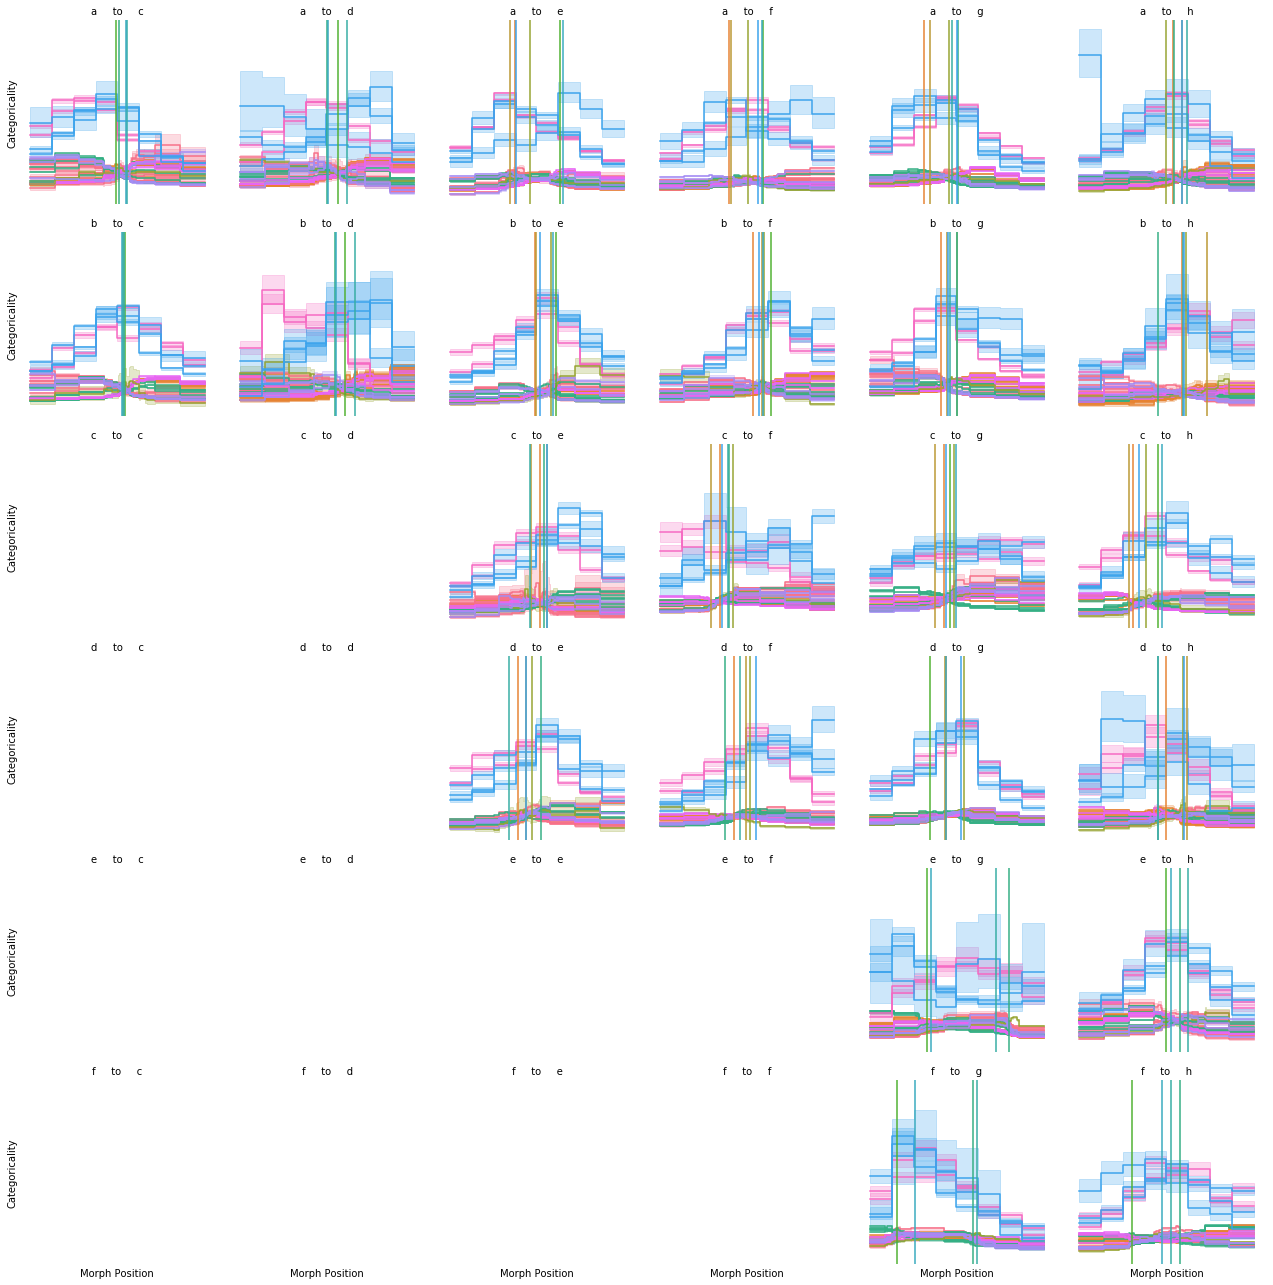

In [9]:
cat_viz(cat_df)

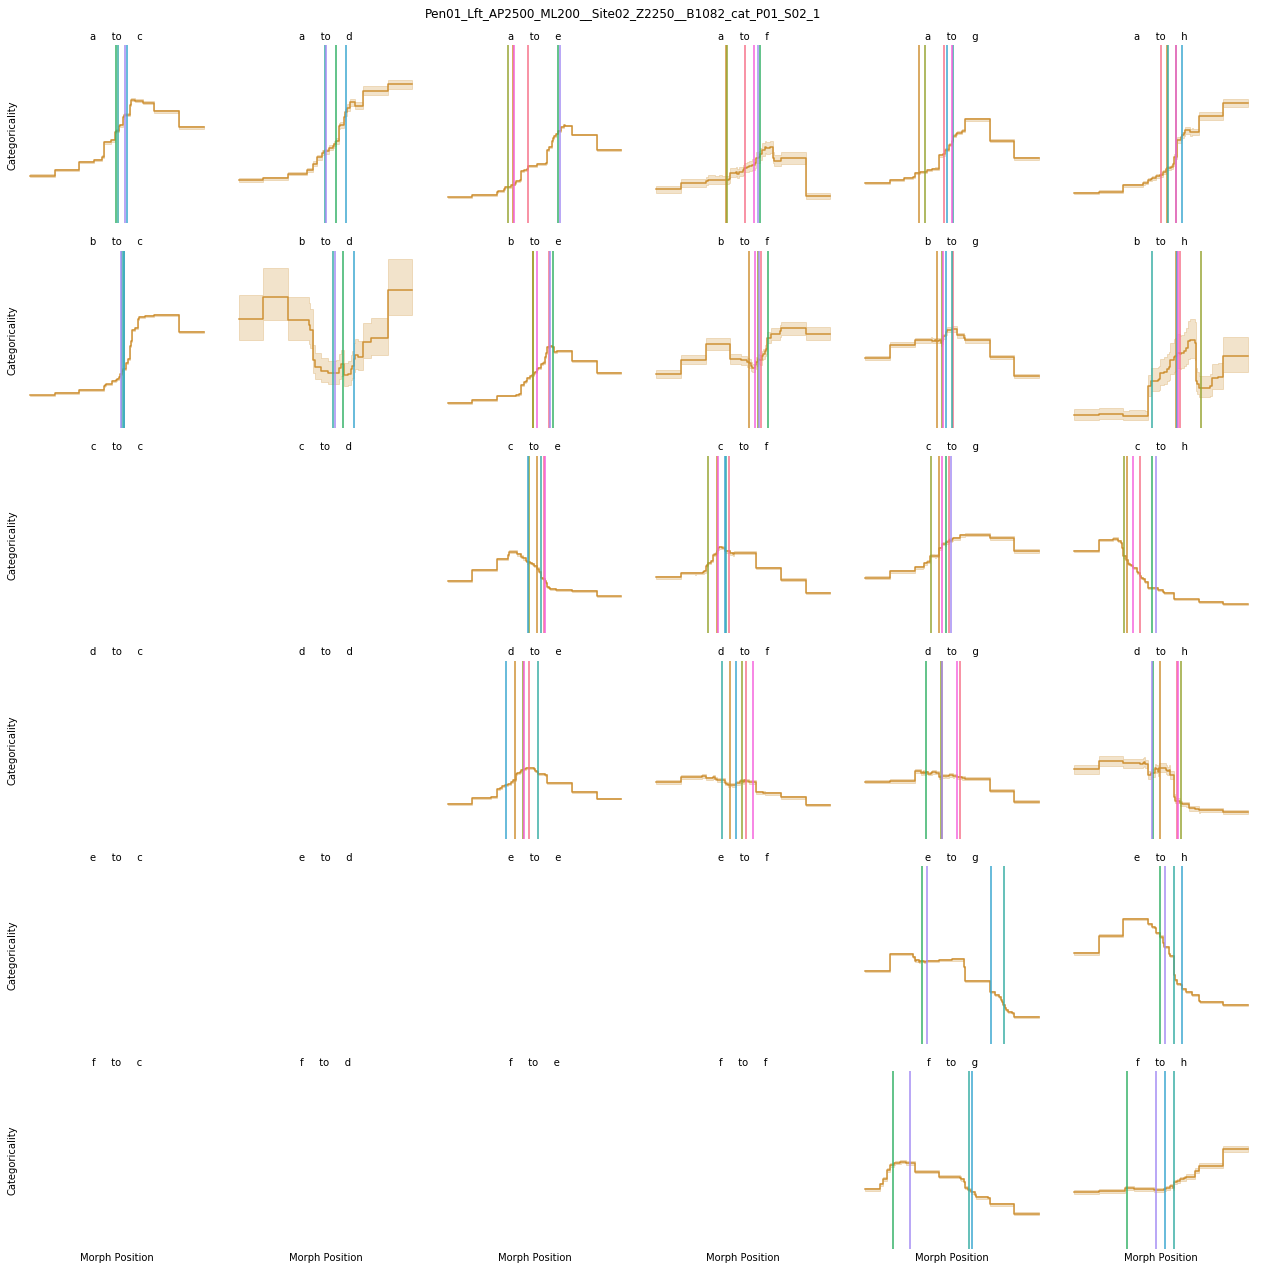

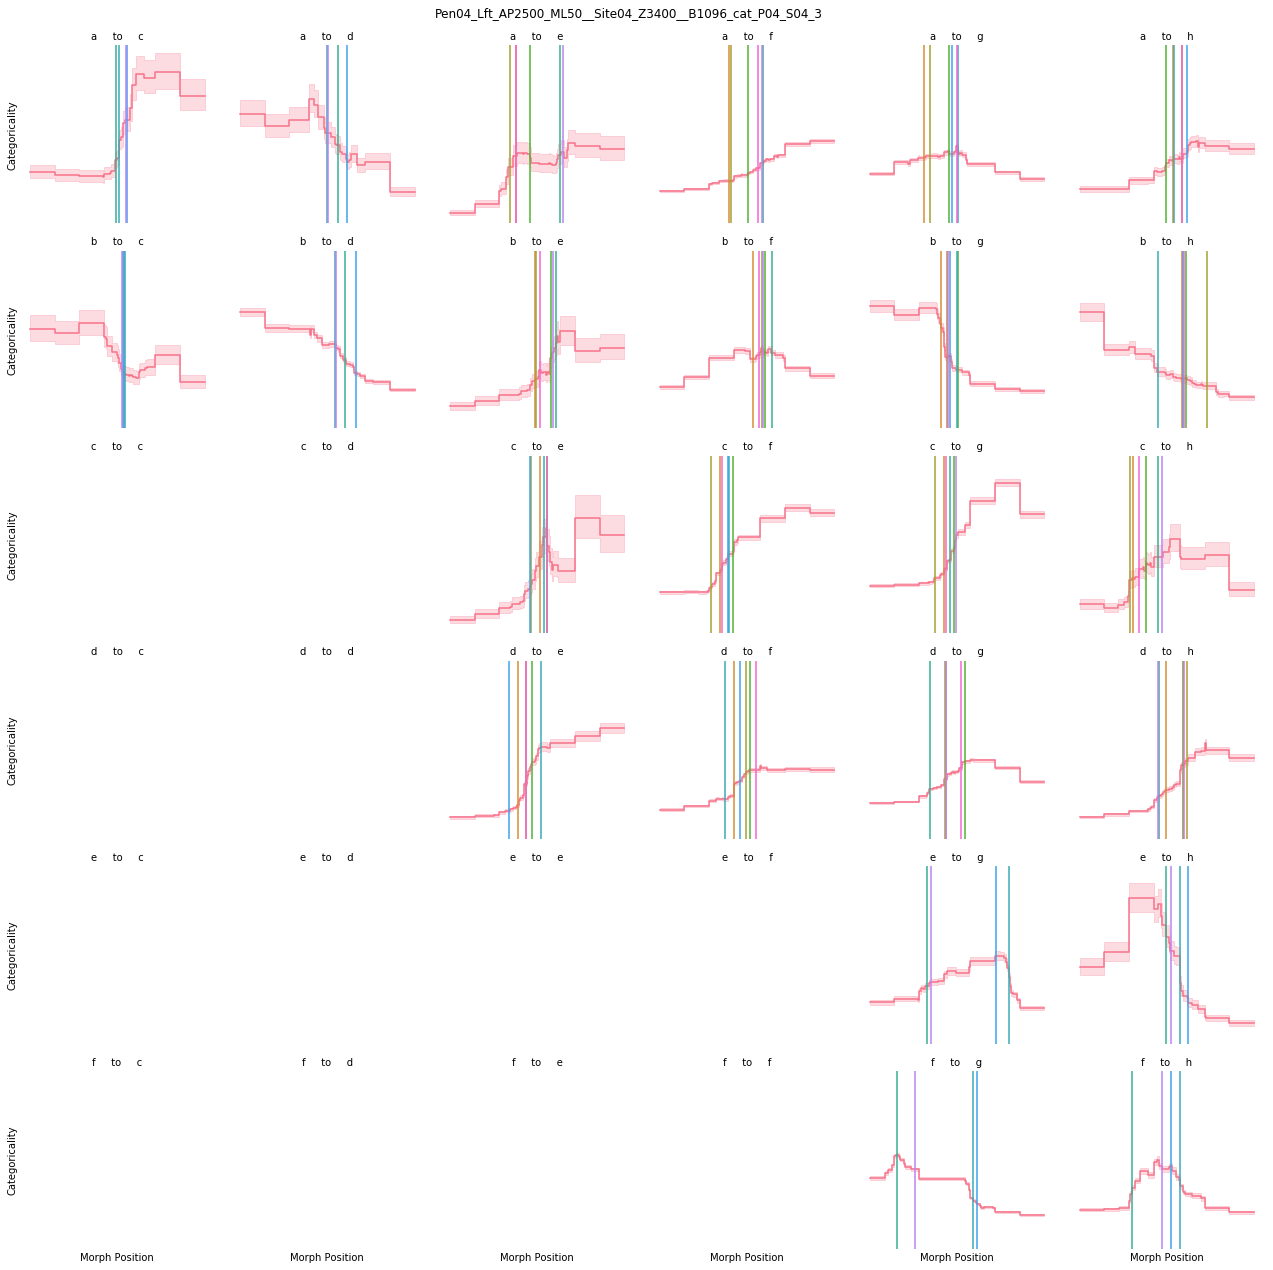

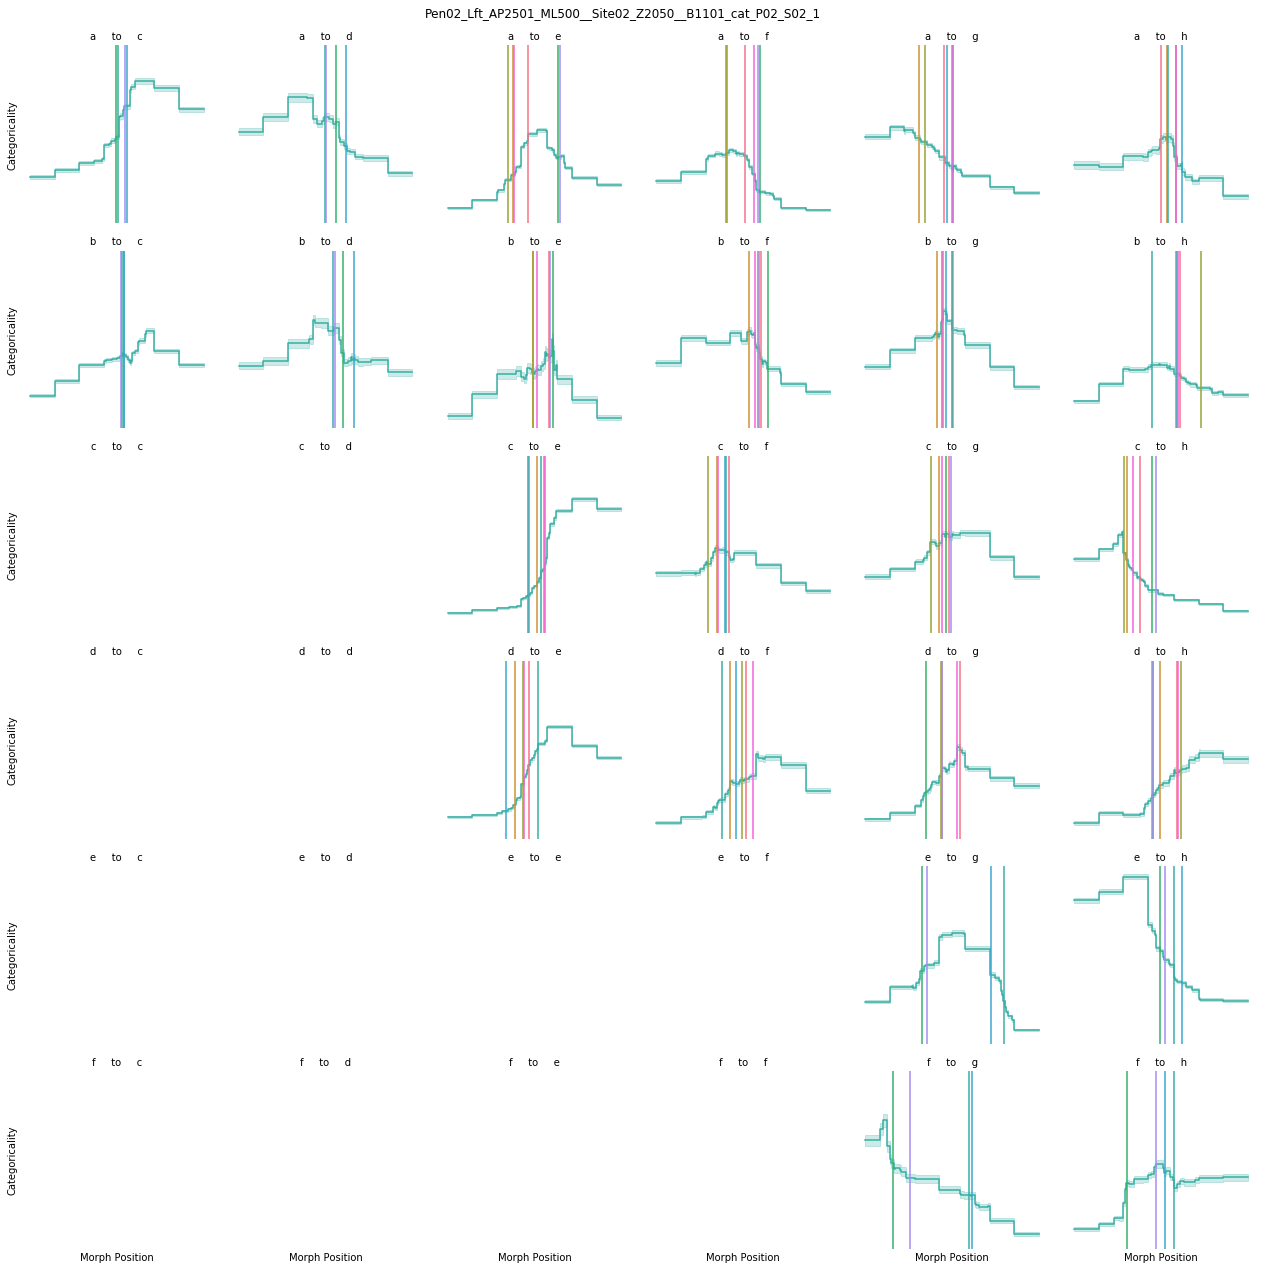

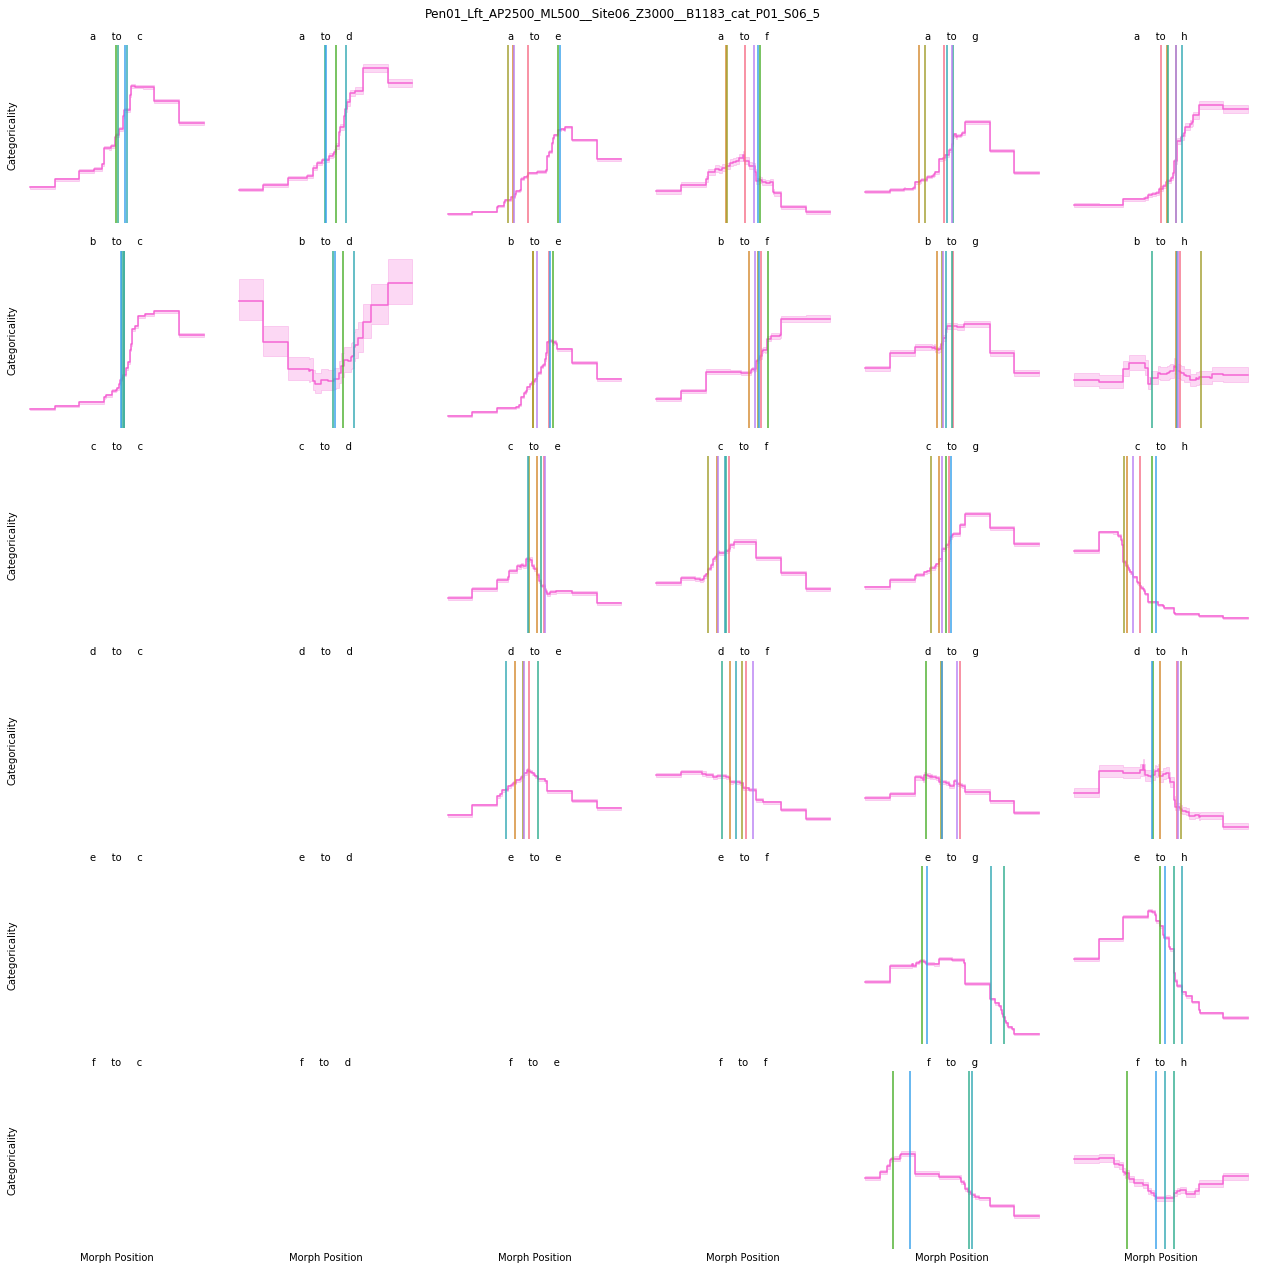

In [10]:
for i, (block_path, block_group) in enumerate(cat_df.groupby('block_path')):
    if i % 10 == 0:
        cat_viz(block_group, title=morphs.data.parse.blockpath_name(block_path))

In [11]:
controlled_cat_df = pair_df.groupby(['block_path', 'morph_dim']).apply(categorical, spect_dist_control=True)

In [12]:
controlled_cat_df = controlled_cat_df.to_frame().reset_index()
morphs.data.parse.morph_dim(controlled_cat_df)
controlled_cat_df['bird_id'] = controlled_cat_df['block_path'].map(morphs.data.parse.bird_id)

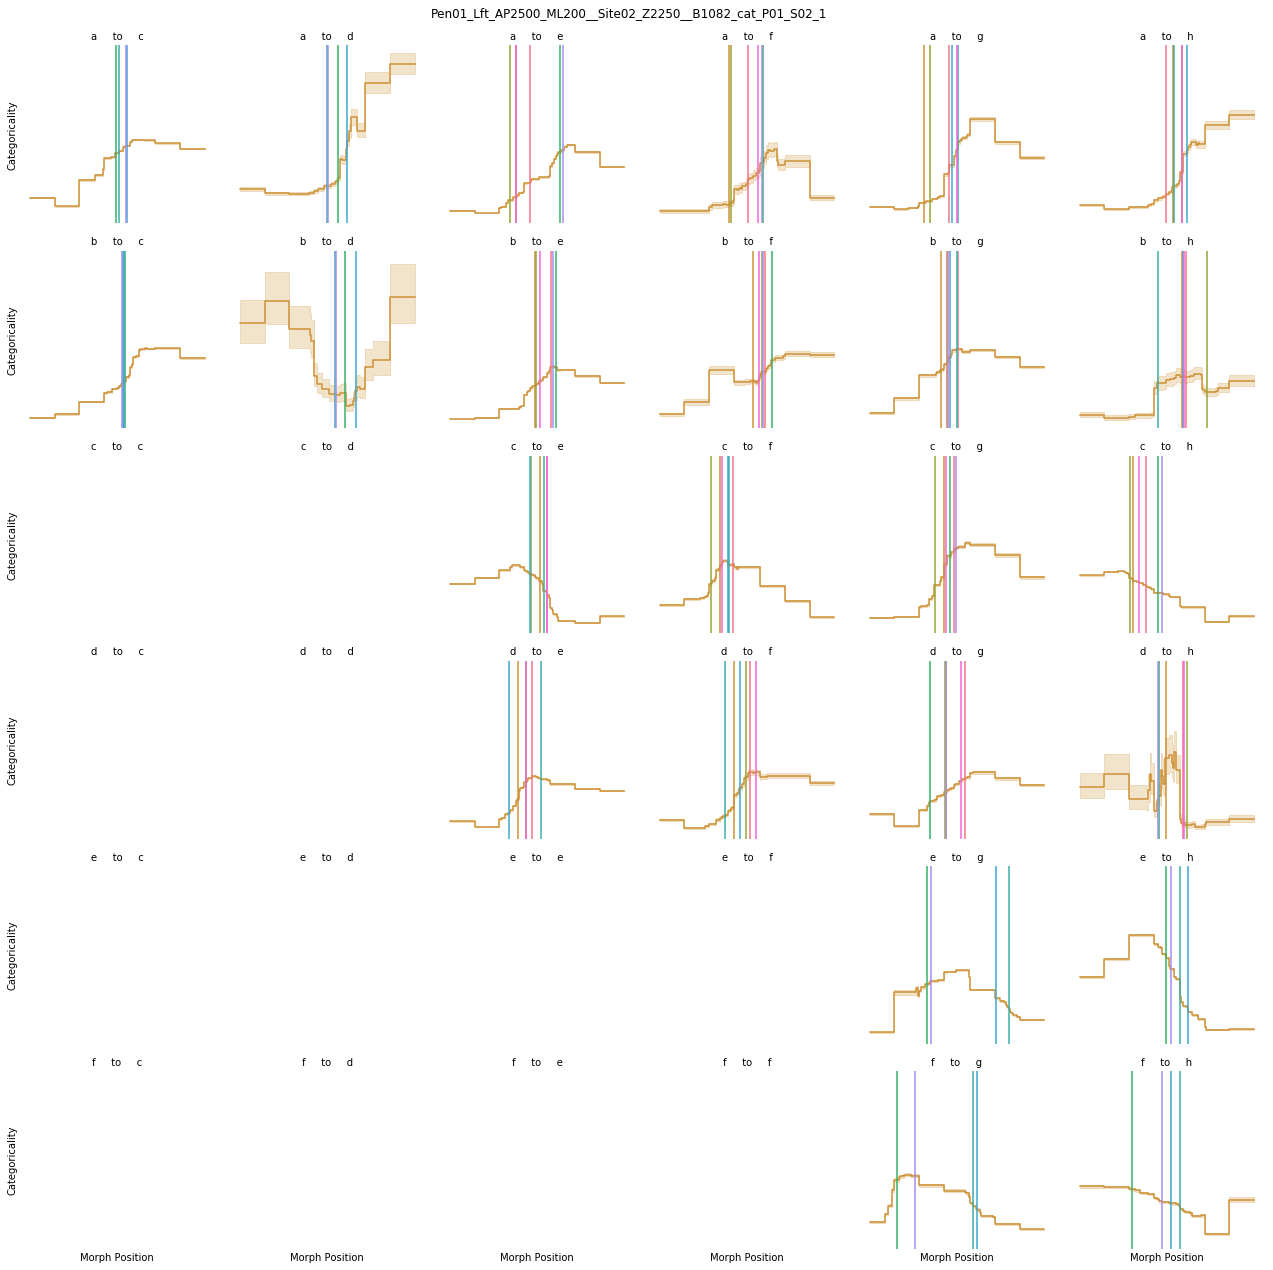

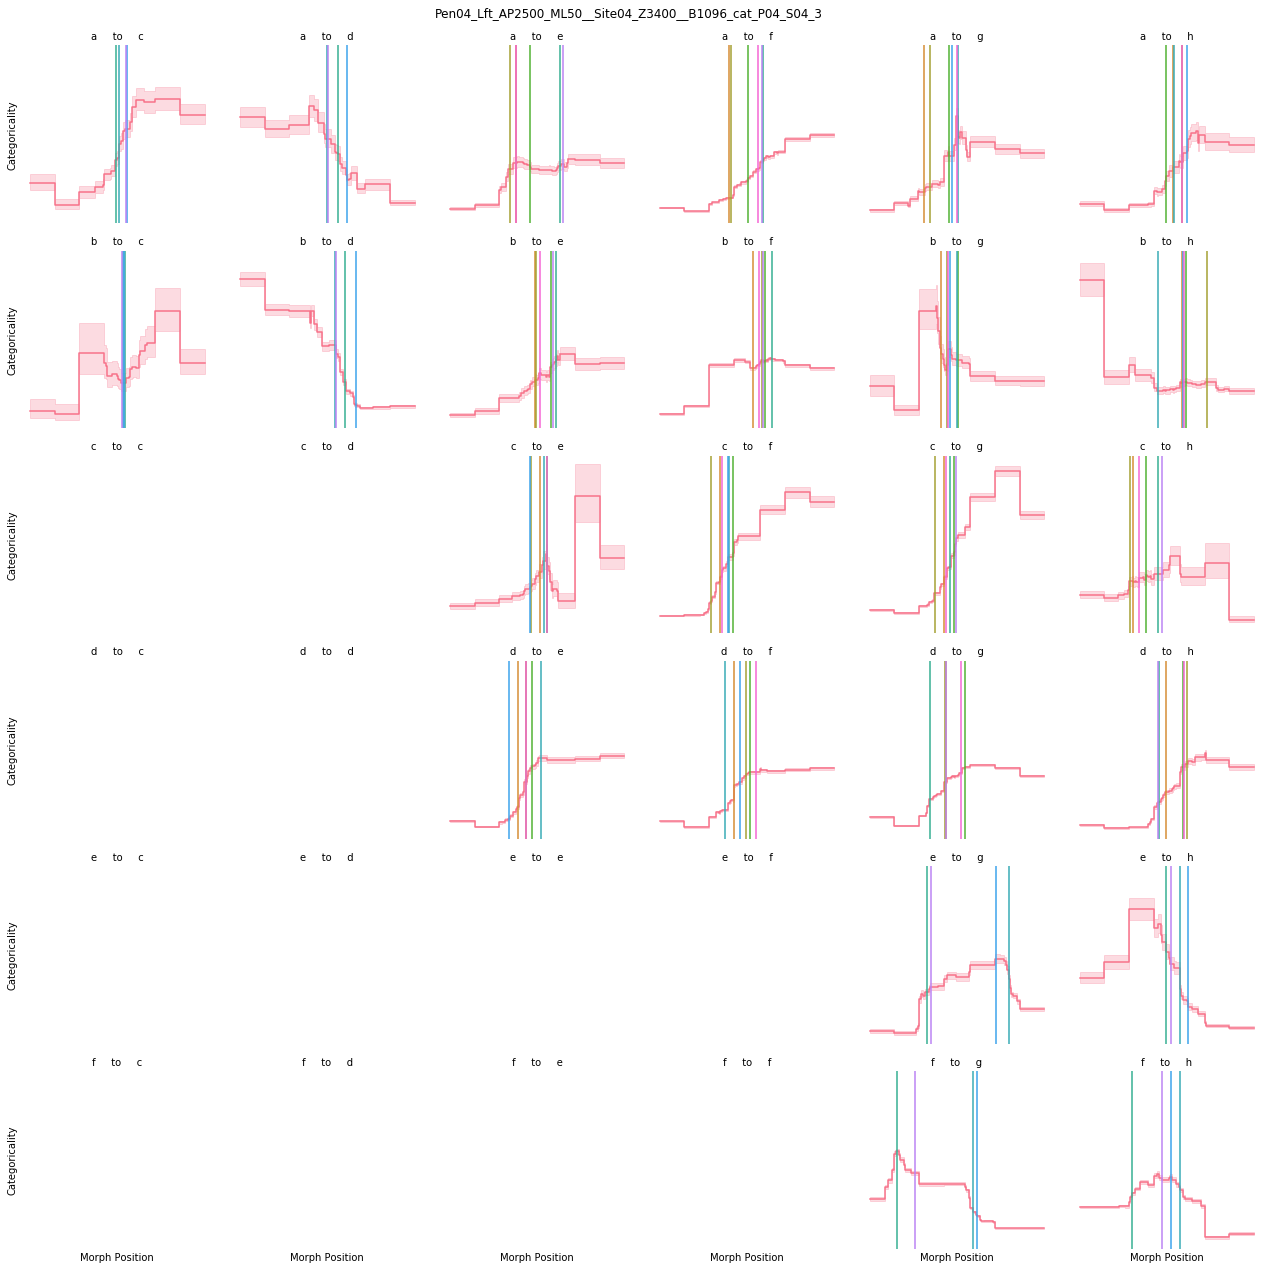

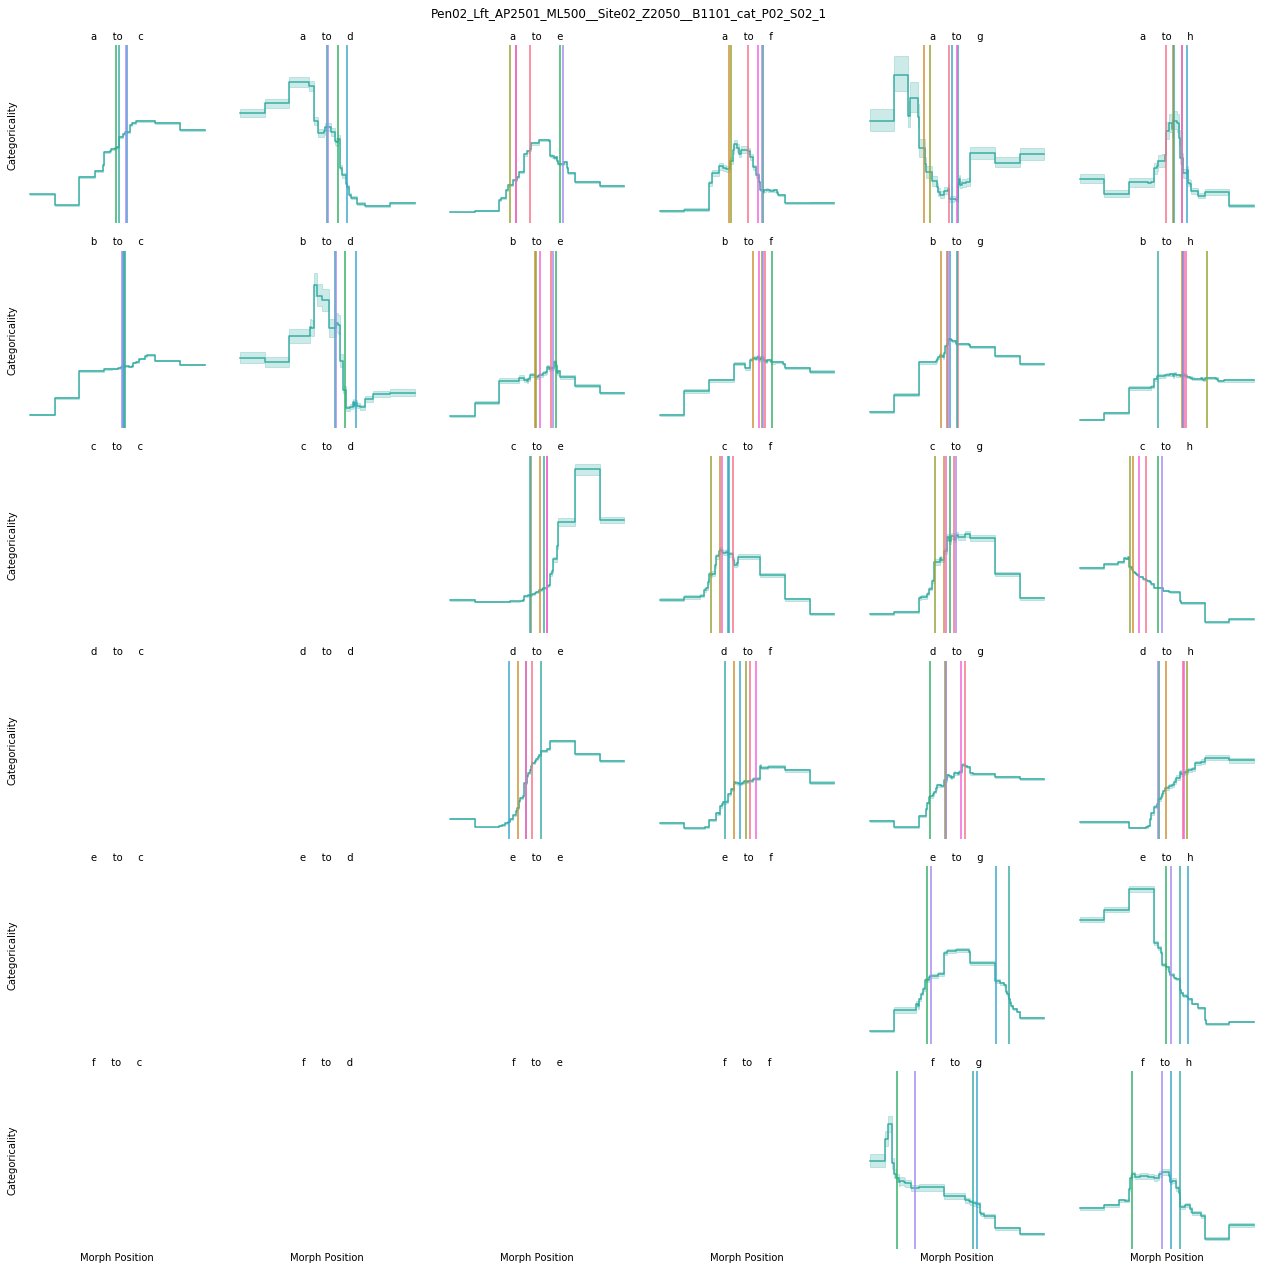

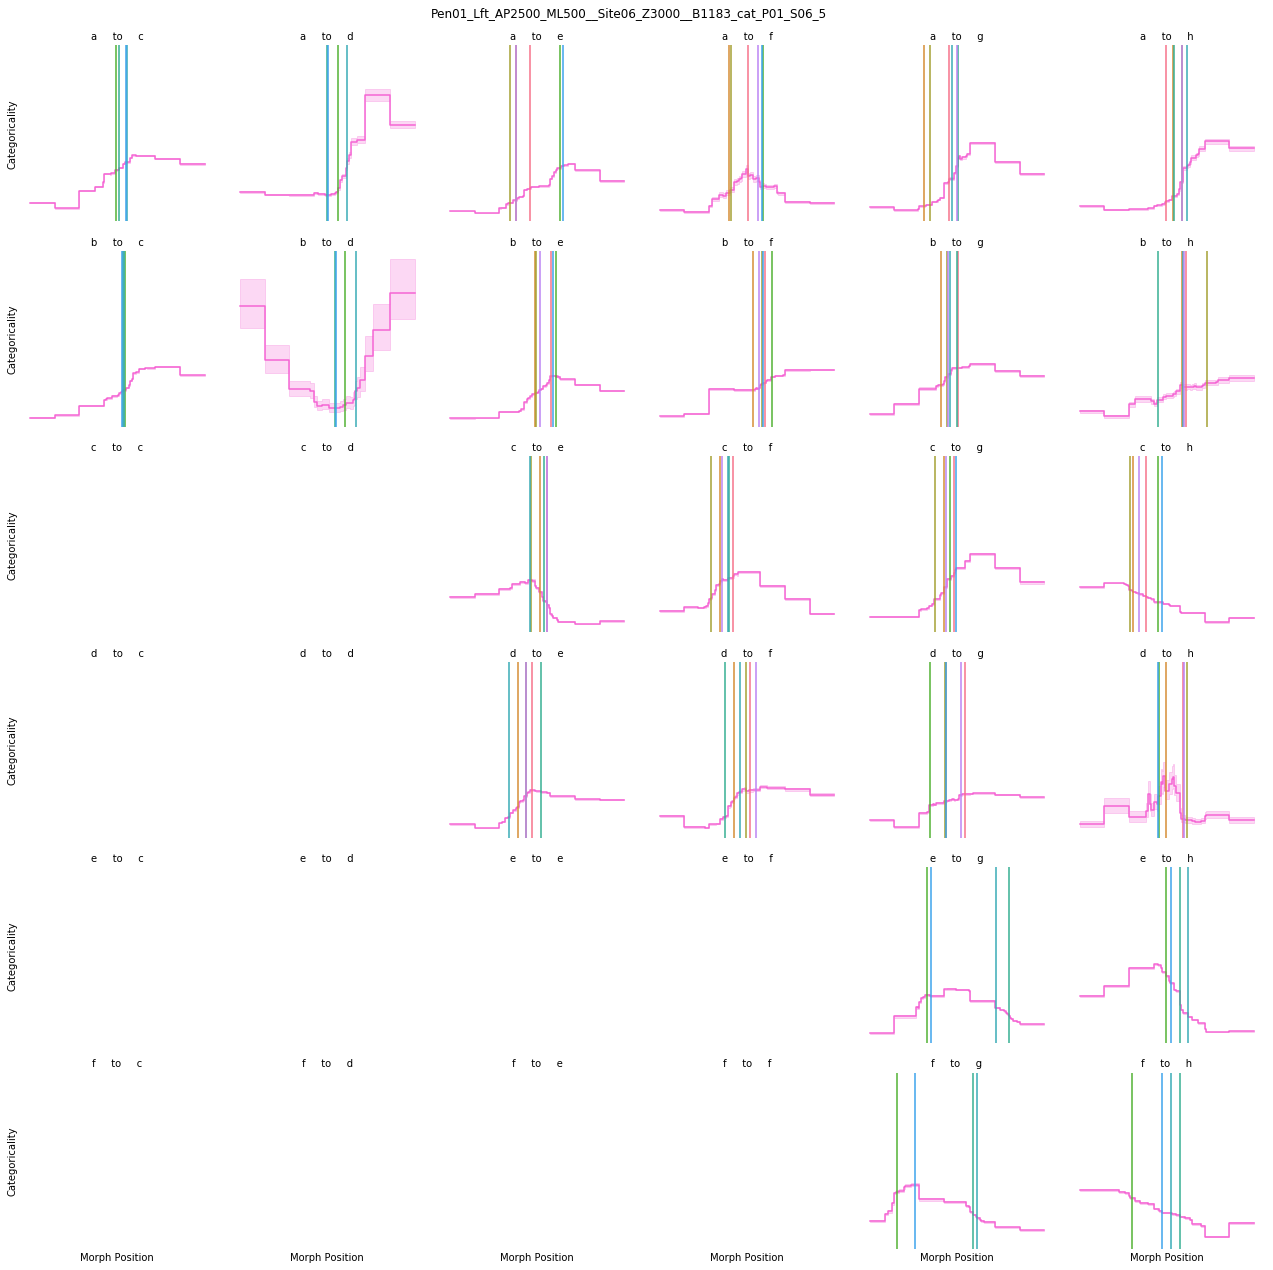

In [13]:
for i, (block_path, block_group) in enumerate(controlled_cat_df.groupby('block_path')):
    if i % 10 == 0:
        cat_viz(block_group, title=morphs.data.parse.blockpath_name(block_path))